## Import das bibliotecas utilizadas


In [43]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import multimode
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from prophet.diagnostics import performance_metrics
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt




### Carregamento dos dados para a parte de Análise das métricas

In [44]:
metrics_prophet = pd.read_csv(r'../../Projeto/Data/Metrics/metrics_prophet.csv')
metrics_hw = pd.read_csv(r'../../Projeto/Data/Metrics/metrics_hw.csv')
metrics_pred_simple_exp_smoot = pd.read_csv(r'../../Projeto/Data/Metrics/metrics_pred_simple_exp_smoot.csv')
metrics_predictions_sarimax_exog = pd.read_csv(r'../../Projeto/Data/Metrics/metrics_predictions_sarimax_exog.csv')
metrics_predictions_sarimax_no_exog = pd.read_csv(r'../../Projeto/Data/Metrics/metrics_predictions_sarimax_no_exog.csv')
metrics_predictions_autoarima = pd.read_csv(r'../../Projeto/Data/Metrics/metrics_predictions_autoarima.csv')


In [45]:
df_transposed_copy_inputting_v19 = pd.read_csv(r'../../Projeto/Data/Output/df_transposed_copy_inputting_v19.csv')
df_model = df_transposed_copy_inputting_v19.copy()
df_model['year'] = pd.to_datetime(df_model['year'], format='ISO8601')
df_model.set_index('year', inplace = True)
df_model.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49 entries, 1980-01-01 to 2028-01-01
Columns: 228 entries, Afghanistan to World
dtypes: float64(228)
memory usage: 87.7 KB


## Análise de métricas vs modelos

As métricas MAE (Erro Absoluto Médio), RMSE (Raiz do Erro Quadrático Médio) e MAPE (Erro Percentual Absoluto Médio) são importantes para avaliar o desempenho de um modelo de ciência de dados. Elas medem a diferença entre os valores previstos pelo modelo e os valores reais observados. <br/><br/> - O MAE mede a magnitude média dos erros, enquanto o RMSE dá mais peso aos erros grandes, pois eleva ao quadrado as diferenças antes de calcular a média. <br/><br/> - O MAPE mede o erro em termos percentuais, o que pode ser útil quando os valores observados variam em magnitude. <br/><br/> Ao comparar diferentes modelos, é importante escolher aquele que apresenta o menor valor para essas métricas, indicando que suas previsões são mais precisas.

A média, a mediana e o desvio padrão são medidas estatísticas que podem ser usadas para analisar um conjunto de dados. <br/><br/>
 - A média é a soma de todos os valores dividida pelo número de valores e representa o valor central do conjunto de dados. 
 - A mediana é o valor que divide o conjunto de dados em duas metades iguais, ou seja, metade dos valores estão acima da mediana e metade estão abaixo.
 - O desvio padrão mede o quanto os valores do conjunto de dados se desviam da média. Um desvio padrão alto indica que os valores estão mais dispersos, enquanto um desvio padrão baixo indica que os valores estão mais proximos da média. 


### Análise pela métrica MAE

O MAE (Erro Absoluto Médio) é uma métrica comum para avaliação de desempenho de modelos de previsão de séries temporais. O MAE mede a magnitude média dos erros (magnitude do erro é uma medida da diferença entre os valores previstos por um modelo e os valores reais observados, seu valor indica o queão precisa foi a previsão.)


 - Média: Um modelo com um valor menor de MAE médio é considerado melhor, pois suas previsões são mais precisas.
 - Mediana: A mediana do MAE é uma medida mais robusta a outliers, pois não é afetada por valores extremos.
 - Desvio padrão: Um modelo com desvio padrão baixo para o MAE é considerado mais consistente, pois seus erros de previsão são mais próximos da média. 

In [46]:
final_metrics = pd.DataFrame()
metric = 'MAE'

statistics = [
    'mean',
    'median',
    'std',
    'min',
    'max',
]
final_metrics = pd.concat([final_metrics, metrics_prophet[metric].agg(statistics)], axis=1)

# add simples smothing
final_metrics = pd.concat([final_metrics, metrics_pred_simple_exp_smoot[metric].agg([statistics])], axis=1)

# add sarimax
final_metrics = pd.concat([final_metrics, metrics_predictions_sarimax_exog[metric].agg([statistics])], axis=1)
# add sarimax non exog
final_metrics = pd.concat([final_metrics, metrics_predictions_sarimax_no_exog[metric].agg([statistics])], axis=1)
# add autoarima
final_metrics = pd.concat([final_metrics, metrics_predictions_autoarima[metric].agg([statistics])], axis=1)
# add hw
final_metrics = pd.concat([final_metrics, metrics_hw[metric].agg([statistics])], axis=1)

final_metrics.columns = ['prophet','simple_smoothing','sarimax', 'sarimax no exog', 'autoarima', 'Holt-Winters']

final_metrics = final_metrics.T

final_metrics['cv'] = final_metrics['std'] /final_metrics['mean']  
final_metrics.style.highlight_min(color='lightgreen', axis=0)

,mean,median,std,min,max,cv
prophet,1.672544,0.965000,1.991240,0.130000,18.670000,1.190546
simple_smoothing,1.459956,0.830000,2.350343,0.110000,24.170000,1.609872
sarimax,2.566447,1.200000,5.522633,0.020000,57.040000,2.151859
sarimax no exog,2.566447,1.200000,5.522633,0.020000,57.040000,2.151859
autoarima,2.146535,1.735000,2.440237,0.100000,24.830000,1.136826
Holt-Winters,2.515088,1.335000,5.304481,0.150000,74.200000,2.109064


Pela métrica MAE os modelos que melhor performaram foram os SARIMAX (com e sem variável exógena)

### Avaliação pela métrica MAPE

O MAPE (Erro percentual absoluto médio) é também uma métrica comum para avaliar o desempenho dos modelos de previsão de séries temporais. O MAPE mede o erro em termos percentuais.


 - Média: Um modelo com um valor menor de MAPE médio é considerado melhor, pois suas previsões são mais precisas.
 - Mediana: A mediana do MAPE é uma medida mais robusta a outliers, pois não é afetada por valores extremos.
 - Desvio padrão: Um modelo com desvio padrão baixo para o MAPE é considerado mais consistente, pois seus erros de previsão são mais próximos da média. 

In [47]:
final_metrics = pd.DataFrame()
metric = 'MAPE'

statistics = [
    'mean',
    'median',
    'std',
    'min',
    'max',
]
final_metrics = pd.concat([final_metrics, metrics_prophet[metric].agg(statistics)], axis=1)

# add simples smothing
final_metrics = pd.concat([final_metrics, metrics_pred_simple_exp_smoot[metric].agg([statistics])], axis=1)

# add sarimax
final_metrics = pd.concat([final_metrics, metrics_predictions_sarimax_exog[metric].agg([statistics])], axis=1)
# add sarimax non exog
final_metrics = pd.concat([final_metrics, metrics_predictions_sarimax_no_exog[metric].agg([statistics])], axis=1)
# add autoarima
final_metrics = pd.concat([final_metrics, metrics_predictions_autoarima[metric].agg([statistics])], axis=1)
# add hw
final_metrics = pd.concat([final_metrics, metrics_hw[metric].agg([statistics])], axis=1)

final_metrics.columns = ['prophet','simple_smoothing','sarimax', 'sarimax no exog', 'autoarima', 'Holt-Winters']

final_metrics = final_metrics.T

final_metrics['cv'] = final_metrics['std'] /final_metrics['mean']  
final_metrics.style.highlight_min(color='lightgreen', axis=0)

,mean,median,std,min,max,cv
prophet,65.165499,32.221438,137.931462,2.306472,1776.535147,2.116633
simple_smoothing,inf,30.338619,nan,2.753509,inf,nan
sarimax,116.407171,36.372434,378.860809,0.392157,4683.011894,3.254617
sarimax no exog,116.407171,36.372434,378.860809,0.392157,4683.011894,3.254617
autoarima,63.101014,59.745748,54.043107,1.680763,562.484243,0.856454
Holt-Winters,inf,50.675165,nan,5.068382,inf,nan


Para o MAPE o modelo que melhor performou foi o autoarima, apesar do SARIMAX obter a melhor média.

### Avaliação pelo método RMSE

O RMSE (Raiz do Erro Quadrático Médio) é uma métrica comum para avaliar o desempenho de modelos de previsão. Ele mede a diferença entre os valores previstos pelo modelo e os valores reais observados, elevando ao quadrado as diferenças antes de calcular a média e, em seguida, tirando a raiz quadrada do resultado. Isso dá mais peso aos erros grandes, pois eles são elevados ao quadrado antes de serem somados. O RMSE é útil quando se deseja penalizar erros grandes e pode ser usado para comparar o desempenho de diferentes modelos. Um modelo com um valor menor de RMSE é considerado melhor, pois suas previsões são mais precisas.


 - Média: Um modelo com um valor menor de RMSE médio é considerado melhor, pois suas previsões são mais precisas.
 - Mediana: A mediana do RMSE é uma medida mais robusta a outliers, pois não é afetada por valores extremos.
 - Desvio padrão: Um modelo com desvio padrão baixo para o RMSE é considerado mais consistente, pois seus erros de previsão são mais próximos da média. 

In [48]:
final_metrics = pd.DataFrame()
metric = 'RMSE'

statistics = [
    'mean',
    'median',
    'std',
    'min',
    'max',
]
final_metrics = pd.concat([final_metrics, metrics_prophet[metric].agg(statistics)], axis=1)

# add simples smothing
final_metrics = pd.concat([final_metrics, metrics_pred_simple_exp_smoot[metric].agg([statistics])], axis=1)

# add sarimax
final_metrics = pd.concat([final_metrics, metrics_predictions_sarimax_exog[metric].agg([statistics])], axis=1)
# add sarimax non exog
final_metrics = pd.concat([final_metrics, metrics_predictions_sarimax_no_exog[metric].agg([statistics])], axis=1)
# add autoarima
final_metrics = pd.concat([final_metrics, metrics_predictions_autoarima[metric].agg([statistics])], axis=1)
# add hw
final_metrics = pd.concat([final_metrics, metrics_hw[metric].agg([statistics])], axis=1)

final_metrics.columns = ['prophet','simple_smoothing','sarimax', 'sarimax no exog', 'autoarima', 'Holt-Winters']

final_metrics = final_metrics.T

final_metrics['cv'] = final_metrics['std'] /final_metrics['mean']  
final_metrics.style.highlight_min(color='lightgreen', axis=0)

,mean,median,std,min,max,cv
prophet,1.822105,1.080000,2.125825,0.140000,19.080000,1.166686
simple_smoothing,1.633070,0.910000,2.744476,0.140000,31.290000,1.680562
sarimax,2.833509,1.280000,6.029653,0.040000,61.130000,2.127981
sarimax no exog,2.833509,1.280000,6.029653,0.040000,61.130000,2.127981
autoarima,2.274868,1.820000,2.738406,0.120000,27.300000,1.203765
Holt-Winters,2.885307,1.590000,6.050021,0.190000,83.570000,2.096838


Com a métrica de RMSE o modelo que melhor performou foi o Prophet

### Cross-Validation

#### Simple Exponential Smoothing

A validação cruzada consiste em dividir o conjunto de dados em partes, ajustar o modelo em uma parte dos dados (chamada de conjunto de treinamento) e avaliar o desempenho do modelo na outra parte dos dados (chamada de conjunto de teste).<br/><br/> Esse processo é repetido várias vezes, com diferentes divisões dos dados, para obter uma estimativa mais precisa do desempenho do modelo. 

In [49]:
test_years = 5
train_data = df_model.iloc[:-test_years, :]
test_data = df_model.iloc[-test_years:, :]


In [50]:
#MAPE function
def MAPE(df_model_true, df_model_pred):
    df_model_true, df_model_pred = np.array(df_model_true), np.array(df_model_pred)
    return np.mean(np.abs((df_model_true - df_model_pred)/ df_model_true)) *100


/home/guest/DS/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/guest/DS/venv/lib/python3.8/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/home/guest/DS/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/guest/DS/venv/lib/python3.8/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/home/guest/DS/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provid

/home/guest/DS/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/guest/DS/venv/lib/python3.8/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/home/guest/DS/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/home/guest/DS/venv/lib/python3.8/site-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/home/guest/DS/venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provid

mean mae for all countrys 3.5710159650786744
median mae for all countrys 2.9310484251307947
std mae for all countrys 2.6853969815552334
std mae for all countrys 24.384808583984533
std mae for all countrys 0.9494750303596001
cv mae for all countrys 0.7519980330012528


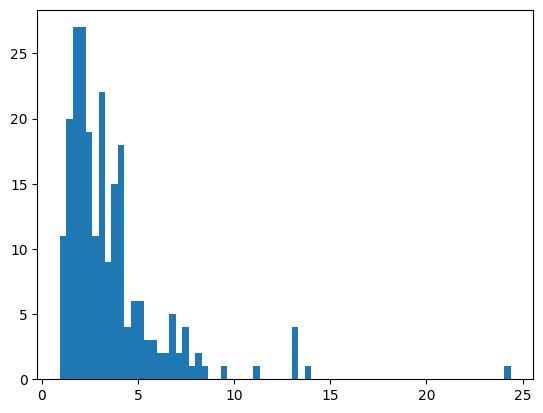

In [51]:
#Create an empty dataframe to store the model metrics
df_final_metrics_simple_exponential_cv = pd.DataFrame()

# Defining the number of splits
n_splits = 5

# Create an object TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)


# Inside the loop for cross-validation splits
for country in df_model.columns:
    final_metrics_cv = pd.DataFrame()
    for train_idx, test_idx in tscv.split(train_data[country]):
        train_data_idx = train_data[country].iloc[train_idx]
        test_data_idx = train_data[country].iloc[test_idx]

        model_simple_exp_smoot = SimpleExpSmoothing(
            train_data_idx,
            #initialization_method='heuristic',                              
            ).fit(smoothing_level=0.2, optimized=True)
        pred_simple_exp_smoot = model_simple_exp_smoot.forecast(test_data_idx.shape[0])
        mae = mean_absolute_error(test_data_idx, pred_simple_exp_smoot)
        final_metrics_cv = pd.concat([final_metrics_cv, pd.DataFrame({country: [mae]})], ignore_index=True)

    df_final_metrics_simple_exponential_cv = pd.concat([df_final_metrics_simple_exponential_cv, final_metrics_cv], axis=1)
aux = df_final_metrics_simple_exponential_cv.mean()

print("mean mae for all countrys",aux.values.mean())
print("median mae for all countrys",np.median(aux.values))
print("std mae for all countrys",aux.values.std())
print("std mae for all countrys",aux.values.max())
print("std mae for all countrys",aux.values.min())
print("cv mae for all countrys",aux.values.std() / aux.values.mean())
plt.hist(aux.values, bins=70);

In [52]:
metrics_predictions_simple_exponential_cv = pd.DataFrame()
metrics_results = []
for country in df_model.columns:
    mae = (round(mean_absolute_error(test_data[country], df_final_metrics_simple_exponential_cv[country]),2))
    rmse = (round(np.sqrt(mean_squared_error(test_data[country], df_final_metrics_simple_exponential_cv[country])),2))
    mape = (MAPE(test_data[country], df_final_metrics_simple_exponential_cv[country]))
    #print(f"Country: {country}")
    #print(f"MAE: {mae}")
    #print(f"RMSE: {rmse}")
    #print(f"MAPE: {mape}")
    #print("=============")
    metrics_results.append({
        "Country": country,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    })

metrics_predictions_simple_exponential_cv = pd.DataFrame(metrics_results)
metrics_predictions_simple_exponential_cv.to_csv('../../Projeto/Data/Metrics/metrics_predictions_simple_exponential_cv.csv', index = True)

### Asserção entre Simple Exponential Smoothing e Prophet

In [54]:
df_final_metrics_cv_prophet = pd.read_csv(r'../../Projeto/Data/Metrics/metrics_cv_prophet.csv')
df_final_metrics_cv_simple_exponential = pd.read_csv(r'../../Projeto/Data/Metrics/metrics_predictions_simple_exponential_cv.csv')

In [55]:
df_final_metrics_cv_prophet = df_final_metrics_cv_prophet.rename(columns=str.upper)

In [56]:
df_final_metrics_cv_prophet.head()

,COUNTRY,HORIZON,MSE,RMSE,MAE,MAPE,MDAPE,SMAPE,COVERAGE
0,ASEAN-5,1077 days 01:33:54.782608688,23.962234,4.362962,3.053487,0.505071,0.303880,0.569818,0.710145
1,Advanced economies,1077 days 01:33:54.782608688,5.250921,2.200946,1.563374,0.828490,0.376068,0.513594,0.633540
2,Afghanistan,1077 days 01:33:54.782608688,22.921299,4.612654,3.538939,1.166037,0.454541,0.595841,0.434783
3,Africa (Region),1077 days 01:33:54.782608688,7.985641,2.712952,2.309659,2.211579,0.491484,0.664574,0.507246
4,Albania,1077 days 01:33:54.782608688,71.991437,8.108372,6.244776,1.324796,1.116433,1.125820,0.641822


In [57]:
final_metrics_cv = pd.DataFrame()
metrics = 'MAE'

statistics = [
    'mean',
    'median',
    'std',
    'min',
    'max',
]
final_metrics_cv = pd.concat([final_metrics_cv, df_final_metrics_cv_prophet[metric].agg(statistics)], axis=1)

# add simple exponential
final_metrics_cv = pd.concat([final_metrics_cv, df_final_metrics_cv_simple_exponential[metric].agg([statistics])], axis=1)

final_metrics_cv.columns = ['prophet', 'simple exponential']
final_metrics_cv = final_metrics_cv.T

final_metrics_cv['cv'] = final_metrics_cv['std'] /final_metrics_cv['mean']  
final_metrics_cv.style.highlight_min(color='lightgreen', axis=0)


,mean,median,std,min,max,cv
prophet,6.377815,5.115841,4.524085,1.221269,39.393315,0.709347
simple exponential,3.028816,2.020000,3.574959,0.370000,33.500000,1.180316


Após realizada a validação cruzada entre os modelos Prophet e Simple Exponential Smoothing e avaliada as métricas obtidas, o modelo que melhor performou foi o Simple Exponential Smoothing, sendo este o modelo a ser escolhido para realizar as previsões finais. 